In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingClassifier as XGB
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [240]:
# load data
df_cal = pd.read_csv('../data/calendar.csv')
df_list = pd.read_csv('../data/listings.csv')
df_rev = pd.read_csv('../data/reviews.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Data Wrangling

#### calendar dataset

In [241]:
# Transforming price column to float ($180 -> 180)
df_cal['price_float'] = df_cal['price'].str.replace('$', '')
df_cal['price_float'] = df_cal['price_float'].str.replace(',', '')
df_cal['price_float'] = df_cal['price_float'].astype(float)

In [242]:
#tansform date to datetime
df_cal['date'] = pd.to_datetime(df_cal['date'])

In [243]:
#tansform available to bool
df_cal['available'] = np.where(df_cal['available'] == 't', True, False)

In [244]:
df_cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   listing_id   1393570 non-null  int64         
 1   date         1393570 non-null  datetime64[ns]
 2   available    1393570 non-null  bool          
 3   price        934542 non-null   object        
 4   price_float  934542 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 43.9+ MB


#### listings dataset

In [245]:
# Transforming price column to int ($180 -> 180)

df_list['price_float'] = [price.replace('$', '') for price in df_list['price']]
df_list['price_float'] = [price.replace(',', '') for price in df_list['price_float']]
df_list['price_float'] = df_list['price_float'].astype(float)

In [246]:
# filtering dataset for neighborhoods with at least 20 listings

neighborhoods = []

for hood in df_list['neighbourhood_cleansed'].value_counts().index:
    if df_list['neighbourhood_cleansed'].value_counts()[hood] > 19:
        neighborhoods.append(hood)

df_list = df_list[df_list['neighbourhood_cleansed'].isin(neighborhoods)]

In [247]:
# convert f, t column values to bool (True/False)

bool_cols = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 'has_availability', 'requires_license', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification']
df_list[bool_cols] = np.where(df_list[bool_cols] == 't', True, False)

In [248]:
df_list.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,price_float
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,False,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",True,True,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,True,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,True,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,False,NaN,WASHINGTON,False,moderate,False,False,2,4.07,85.0
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,True,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",True,True,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,True,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,True,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,False,NaN,WASHINGTON,False,strict,True,True,6,1.48,150.0
2,3308979,h

#### reviews dataset

In [249]:
df_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


### Which neighbourhoods are best for hosting?

#### Price

Text(0.5, 1.0, 'Price Comparison by Neighbourhood')

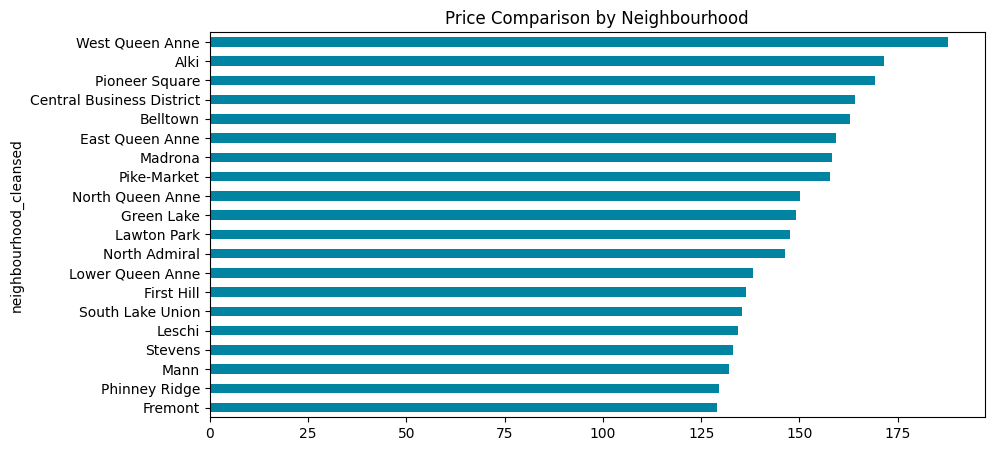

In [250]:
price_by_hood = df_list.groupby('neighbourhood_cleansed')['price_float'].mean().sort_values(ascending=True)[-20:]

fig = plt.figure(figsize = (10, 5))
ax = fig.gca()
price_by_hood.plot(kind='barh', color='#0084a1', width=0.5, ax=ax)
ax.set_title('Price Comparison by Neighbourhood')

#### Reviews per Month

Text(0.5, 1.0, 'Reviews per Month by Neighbourhood')

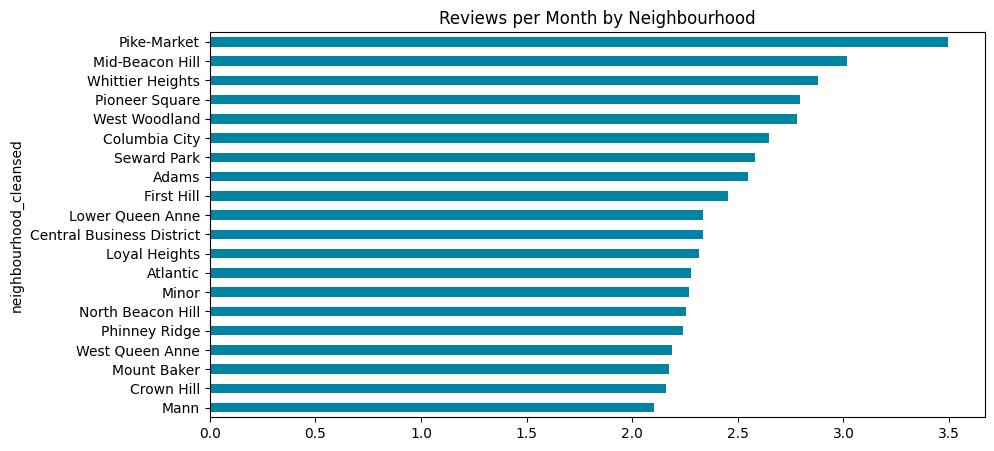

In [251]:
revs_per_month = df_list.groupby('neighbourhood_cleansed')['reviews_per_month'].mean().sort_values(ascending=True)[-20:]

fig = plt.figure(figsize = (10, 5))
ax = fig.gca()
revs_per_month.plot(kind='barh', color='#0084a1', width=0.5, ax=ax)
ax.set_title('Reviews per Month by Neighbourhood')

#### Location Rating

(9.0, 10.0)

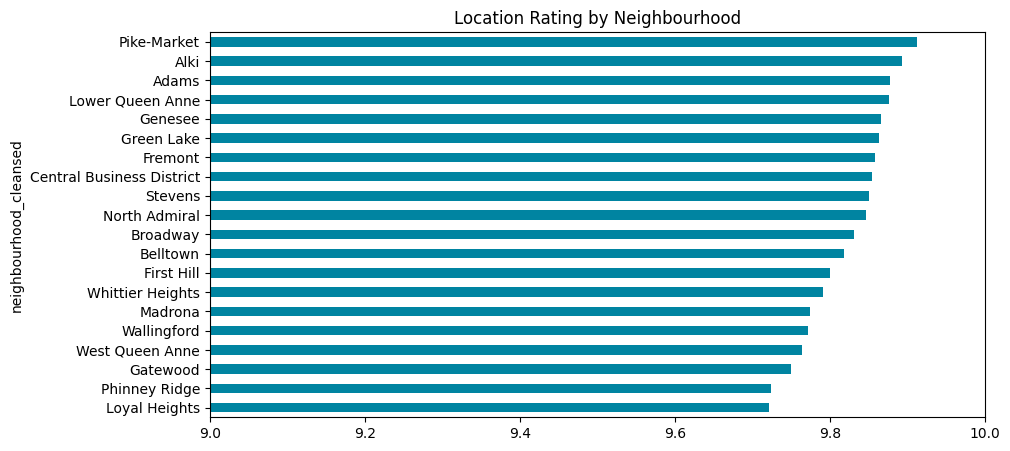

In [252]:
location_rating = df_list.groupby('neighbourhood_cleansed')['review_scores_location'].mean().sort_values(ascending=True)[-20:]

fig = plt.figure(figsize = (10, 5))
ax = fig.gca()
location_rating.plot(kind='barh', color='#0084a1', width=0.5, ax=ax, label=True)
ax.set_title('Location Rating by Neighbourhood')
ax.set_xlim([9,10])

### How does the price fluctuate throughout the year?

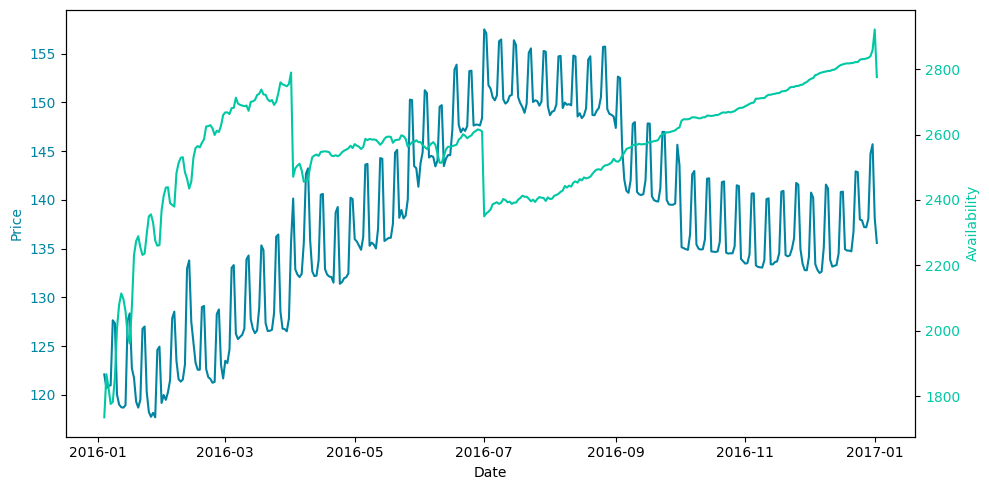

In [253]:
# plot mean price in Seattle over time

price_over_year = df_cal.groupby('date')['price_float'].mean()
avail_over_year = df_cal.groupby('date')['available'].sum()

fig, ax1 = plt.subplots(figsize = (10, 5))
color = '#0084a1'
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color=color)
ax1.plot(price_over_year.index, price_over_year.values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = '#00c7a4'
ax2.set_ylabel('Availability', color=color)  # we already handled the x-label with ax1
ax2.plot(avail_over_year.index, avail_over_year.values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### What is mostly correlated with being a Superhost?

In [254]:
# convert categorical data to dummy variables
cat_cols = ['host_response_time', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 'calendar_updated', 'cancellation_policy']
df_list_feats = pd.get_dummies(df_list, columns=cat_cols)

# filter only int, float and bool columns
df_list_feats = df_list_feats.select_dtypes(include=['float', 'int', 'bool'])

# drop ids, geo data and NaN columns
df_list_feats.drop(['id', 'host_id', 'scrape_id', 'latitude', 'longitude', 'requires_license', 'license', 'has_availability', 'square_feet'], axis=1, inplace=True)

df_list_feats.columns

Index(['host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'is_location_exact',
       'accommodates', 'bathrooms', 'bedrooms', 'beds',
       ...
       'calendar_updated_7 weeks ago', 'calendar_updated_8 months ago',
       'calendar_updated_9 months ago', 'calendar_updated_a week ago',
       'calendar_updated_never', 'calendar_updated_today',
       'calendar_updated_yesterday', 'cancellation_policy_flexible',
       'cancellation_policy_moderate', 'cancellation_policy_strict'],
      dtype='object', length=140)

<Axes: >

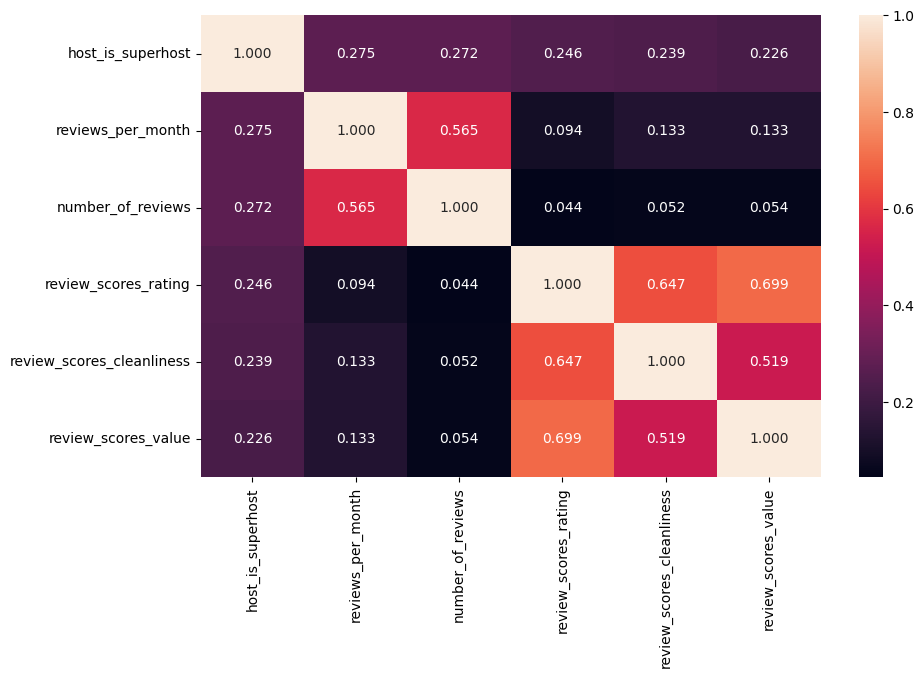

In [255]:
# calculate correlation and plot 5 feats that are mostly correlated in a heatmap
highest_corr_features = df_list_feats.corr().sort_values('host_is_superhost', ascending=False).index[:6]

fig = plt.figure(figsize = (10, 6))
ax = fig.gca()
sns.heatmap(df_list_feats[highest_corr_features].corr(), annot=True,fmt=".3f",ax=ax)

### What aspects of a listing influence the price the most?
#### Run BayesianRidge Regression to find out

In [256]:
# drop rows with NaN values
df_list_feats.dropna(inplace=True)
len(df_list_feats)

2728

In [257]:
# run regression to determine most important factors that influence price

X = df_list_feats.drop('price_float', axis=1)
y = df_list_feats['price_float']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=42)

In [258]:
# Fit regression model

model = BayesianRidge()
model.fit(X_train, y_train)

BayesianRidge()

In [259]:
# apply fitted model to our train and test data

y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_test)

In [284]:
# evaluate model

train_score = round(r2_score(y_train, y_train_preds),3)
test_score = round(r2_score(y_test, y_test_preds), 3)
print(f"The R2 Score of the training set is {train_score} and for the test set is {test_score}")

The R2 Score of the training set is 0.616 and for the test set is 0.639


In [276]:
# feature importance

imp_df = pd.DataFrame({'feature': X_train.columns, 'coefs': model.coef_}).set_index('feature')
imp_df.sort_values(by='coefs', ascending=False)[:10]

,coefs
feature,
calendar_updated_13 months ago,78.882610
neighbourhood_cleansed_Pioneer Square,47.654955
neighbourhood_cleansed_West Queen Anne,43.170301
neighbourhood_cleansed_Pike-Market,37.590686
property_type_Boat,34.984896
room_type_Entire home/apt,34.338899
neighbourhood_cleansed_South Lake Union,32.632194
bathrooms,31.324968
neighbourhood_cleansed_Belltown,31.170069


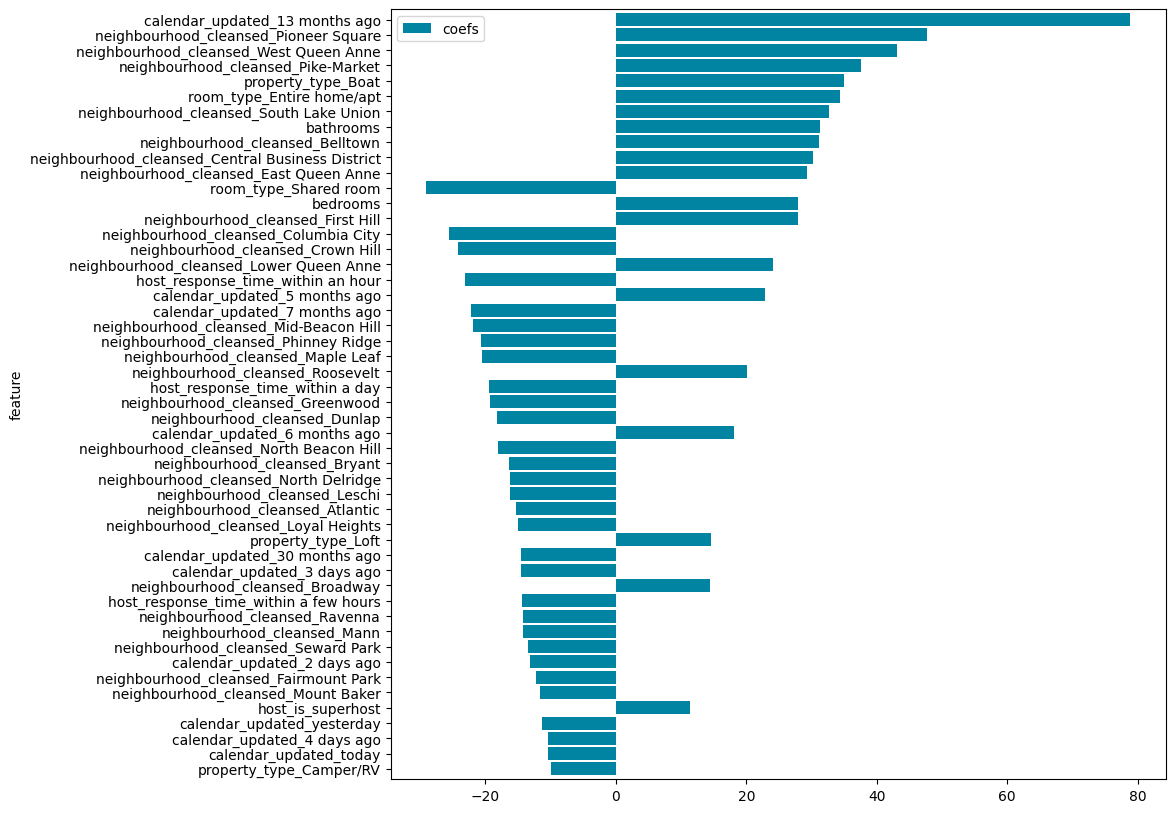

In [282]:
# Create bar chart of the above dataframe

fig = plt.figure(figsize = (10, 10))
ax = fig.gca()
imp_df.reindex(imp_df.abs().sort_values(by='coefs', ascending=False).index).head(50).plot(kind='barh', ax=ax, color='#0084a1', zorder=2, width=0.85)

# imp_df.plot(kind='barh', ax=ax, color='#0084a1', zorder=2, width=0.85)
ax.invert_yaxis()